In [ ]:
!pip install essentia-tensorflow
from essentia.standard import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.4/291.4 MB 5.3 MB/s eta 0:00:00


In [ ]:
!pip install scikit-optimize


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 6.7 MB/s eta 0:00:00


In [ ]:
# import the required instances of the libraries for the models.

from essentia import Pool

from essentia.standard import (
    MonoLoader,
    TensorflowPredict,
    TensorflowPredictMusiCNN,
)

from essentia.standard import TensorflowPredictVGGish

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import numpy as np

# 1 - COMPUTING EMBEDDINGS:

### 1.0 Util functions

In [ ]:
#CREATING X and Y vectors for classification

#We avoid computing 'classical' music genre
#X is infor for each patch. Each patch contains 200 fetures extracted by msd-musicnn model. 128 for audioset-vgg
#Y is the corresponding label to each patch


def x_y_from_embeddings(dir_path):
  data_dict = {
        "mapping": [],
        "labels": [],
        "features": []
    }


  X=[]
  Y=[]
  # Loop through each file in the directory
  for filename in os.listdir(dir_path):
    # Check if the file is a json file
      if filename.endswith('.json'):

          genre= filename.split('/')[-1] .split('.')[0] #extracting genre from filename

          if genre not in data_dict['mapping']: 
            data_dict['mapping'].append(genre)

 
        # Load the json data from the file
          json_file_path= os.path.join(dir_path, filename)
          with open(os.path.join(json_file_path), 'r') as f:
              data = json.load(f)
        
          for d in data:
            X.append(d)
            Y.append (genre)

  X=np.array(X)
  Y=np.array(Y)

  return X, Y




### Compute Embeddings for Musicnn model

In [ ]:

import os
from essentia.standard import MonoLoader, TensorflowPredictVGGish



def compute_embeddings_musicnn(dataset_path, embeddings_path):



  #Configurating VGG model:
  output_layer = "model/dense/BiasAdd"
  model_path= "/content/drive/MyDrive/GTZAN/Models/msd-musicnn-1.pb"

  embedding_model = TensorflowPredictMusiCNN(graphFilename=model_path, 
                                            output=output_layer)

  # Check if folder exists. If not exits, create it
  if not os.path.exists(embeddings_path):
    os.makedirs(embeddings_path)

  # Iterate trough each genre
  for genre in os.listdir(dataset_path):
    
    if genre=='classical' or genre=='Classical' :
        continue
    
    genre_path = os.path.join(dataset_path, genre)
 
 
   
    if os.path.isdir(genre_path):
        for file in os.listdir(genre_path):
            
            if file.endswith(".wav") or file.endswith('mp3'):
              
              fname=os.path.join(genre_path, file)
              datafile = os.path.join(embeddings_path +  file +".json")

              
              if os.path.exists(datafile):
                print("{}. ....... Already computed".format(datafile))
                continue
              
              else:
                print("{}. ....... Computing...".format(datafile))

                audio = MonoLoader(filename=fname, sampleRate=16000)()
                
                embeddings = embedding_model(audio)

                data=embeddings.tolist()
               
                with open(datafile, 'w') as f:
                  json.dump(data, f, indent=2)


### Compute Embeddings for VGG model

In [ ]:
#COMPUTE EMBEDDINGS USING VGG MODEL
import os
from essentia.standard import MonoLoader, TensorflowPredictVGGish



def compute_embeddings_VGG(dataset_path, embeddings_path):



  #Configurating VGG model:
  output_layer = "model/vggish/embeddings"
  model_path= "/content/drive/MyDrive/GTZAN/Models/audioset-vggish-3.pb"

  #Model instatiation
  embedding_model = TensorflowPredictVGGish(graphFilename=model_path, 
                                            output=output_layer)
  
  
  if not os.path.exists(embeddings_path):
  
    os.makedirs(embeddings_path)

  
  for genre in os.listdir(dataset_path):
    
    if genre=='classical' or genre=='Classical' :
        continue
    
    genre_path = os.path.join(dataset_path, genre)
 
 
  
    if os.path.isdir(genre_path):
        for file in os.listdir(genre_path):
            if file.endswith(".wav") or file.endswith('mp3'):
              
              fname=os.path.join(genre_path, file)
              datafile = os.path.join(embeddings_path +  file +".json")

              
              if os.path.exists(datafile):
                print("{}. ....... Already computed".format(datafile))
                continue
              
              else:
                print("{}. ....... Computing...".format(datafile))

                audio = MonoLoader(filename=fname, sampleRate=16000)()
                embeddings = embedding_model(audio)

                data=embeddings.tolist()
               
                with open(datafile, 'w') as f:
                  json.dump(data, f, indent=2)


### Compute Embeddings for EffNet model

In [ ]:
import os
from essentia.standard import MonoLoader, TensorflowPredictMusiCNN



def compute_embeddings_effnet(dataset_path, embeddings_path):
  

  #Effnet-discogs model path
  model_path='/content/drive/MyDrive/GTZAN/Models/effnet-discogs-1.pb'

  #Configuring EffNet EMbeddings:
  patch_size = 128
  patch_hop_size = patch_size // 2

  input_layer = "melspectrogram"
  output_layer = "onnx_tf_prefix_BatchNormalization_496/add_1"


  
  #Embedding model 
  embeddings_model = TensorflowPredictMusiCNN(
    graphFilename=model_path,
    input=input_layer,
    output=output_layer,
    patchSize=patch_size,
    patchHopSize=patch_hop_size,)
  
  
  
  # Chek if embeddings_model_path exits
  if not os.path.exists(embeddings_path):
    # if not, create it
    os.makedirs(embeddings_path)

  # Recorremos cada género musical en el dataset
  for genre in os.listdir(dataset_path):

    #Avoid the computing of 'Classical' audiofiles
    if genre=='classical' or genre=='Classical' :
        continue

    # Creamos la ruta completa a la carpeta del género musical
    genre_path = os.path.join(dataset_path, genre)
    print(genre_path)

    
    if os.path.isdir(genre_path):
        for file in os.listdir(genre_path):
            if file.endswith(".wav") or file.endswith('mp3'):
              
              fname=os.path.join(genre_path, file)
              datafile = os.path.join(embeddings_path +  file +".json")
              
              #If embedding is already stored in json file, we wont compute ir again 
              if os.path.exists(datafile):
                print("{}. ....... Already computed".format(datafile))
                continue
              #else, we compute and save to json file
              else:
                #Computing embedding:
                print("{}. ....... Computing...".format(datafile))
                audio = MonoLoader(filename=fname, sampleRate=16000)()
                embeddings = embeddings_model(audio)
                data=embeddings.tolist()
               #Store the extracted data in json file
                with open(datafile, 'w') as f:
                  json.dump(data, f, indent=2)


##1.1 - Msd-musicnn models

In [64]:
json_file_path = '/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-complete/blues.00000.wav.json'
with open(json_file_path, 'r') as f:
                # Check if the file is not empty
  file_content = f.read()

                # Load the JSON data
  data = json.loads(file_content)
  print('msd-musicnn content:')
  print ('Patches:', len(data))
  print ('Features:', len(data[0]))

msd-musicnn content:
Patches: 19
Features: 200


### 1.1.1 Complete dataset (msd-musicnn)

In [ ]:
dataset_path='/content/drive/MyDrive/GTZAN/genres_original'
embeddings_path='/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-complete/'
compute_embeddings_musicnn(dataset_path, embeddings_path)

/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-complete/blues.00006.wav.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-complete/blues.00002.wav.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-complete/blues.00001.wav.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-complete/blues.00004.wav.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-complete/blues.00007.wav.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-complete/blues.00003.wav.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-complete/blues.00000.wav.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-complete/blues.00005.wav.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-complete/blues.00019.wav.json. ....... 

### 1.1.2 Percussive dataset (msd-musicnn)

In [ ]:
dataset_path='/content/drive/MyDrive/GTZAN/Dataset-Percussive'
embeddings_path='/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-percu/'

compute_embeddings_musicnn(dataset_path, embeddings_path)

### 1.1.3 Harmonic dataset (msd-musicnn)

In [ ]:
dataset_path='/content/drive/MyDrive/GTZAN/Dataset-Harmonic'
embeddings_path='/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-harmo/'

compute_embeddings_musicnn(dataset_path, embeddings_path)

/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-harmo/blues.00006.Harmo.mp3.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-harmo/blues.00002.Harmo.mp3.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-harmo/blues.00001.Harmo.mp3.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-harmo/blues.00004.Harmo.mp3.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-harmo/blues.00007.Harmo.mp3.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-harmo/blues.00003.Harmo.mp3.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-harmo/blues.00000.Harmo.mp3.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-harmo/blues.00005.Harmo.mp3.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-harmo/blues.000

## 1.2 Audionet-VGGish
In this part, the Audionet-VGGish embeddings are computed for our datasets: Complete, Harmonics and Percussive datasets

In [65]:
json_file_path = '/content/drive/MyDrive/GTZAN/Embeddings-Data/audioset-vgg-complete/blues.00000.wav.json'
with open(json_file_path, 'r') as f:
                # Check if the file is not empty
  file_content = f.read()

                # Load the JSON data
  data = json.loads(file_content)
  print('audioset-vgg extracted content:')
  print ('Patches:', len(data))
  print ('Features:', len(data[0]))

msd-musicnn content:
Patches: 32
Features: 128


### 1.2.1 Complete Dataset (Audionet-VGGish)

In [ ]:
dataset_path = '/content/drive/MyDrive/GTZAN/genres_original'
embedding_vgg_complete= '/content/drive/MyDrive/GTZAN/Embeddings-Data/audioset-vgg-complete/'

compute_embeddings_VGG(dataset_path, embedding_vgg_complete)

/content/drive/MyDrive/GTZAN/Embeddings-Data/audioset-vgg-complete/blues.00006.wav.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/audioset-vgg-complete/blues.00002.wav.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/audioset-vgg-complete/blues.00001.wav.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/audioset-vgg-complete/blues.00004.wav.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/audioset-vgg-complete/blues.00007.wav.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/audioset-vgg-complete/blues.00003.wav.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/audioset-vgg-complete/blues.00000.wav.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/audioset-vgg-complete/blues.00005.wav.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/audioset-vgg-complete/blues.00019.wav.json.

### 1.2.2 Percussive Dataset (Audionet-VGGish)

In [ ]:
dataset_path = "/content/drive/MyDrive/GTZAN/Dataset-Percussive"
embeddings_path= '/content/drive/MyDrive/GTZAN/Embeddings-Data/audioset-vgg-percu/'

compute_embeddings_VGG(dataset_path, embeddings_path)

### 1.2.3 Harmonic Dataset (Audionet-VGGish)

In [ ]:
dataset_path = "/content/drive/MyDrive/GTZAN/Dataset-Harmonic"
embeddings_path= '/content/drive/MyDrive/GTZAN/Embeddings-Data/audioset-vgg-harmo/'


compute_embeddings_VGG(dataset_path, embeddings_path)

## 1.3 EffNet:

In [67]:
json_file_path = '/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-complete/blues.00000.wav.json'
with open(json_file_path, 'r') as f:
                # Check if the file is not empty
  file_content = f.read()

                # Load the JSON data
  data = json.loads(file_content)
  print('msd-musicnn content:')
  print ('Patches:', len(data))
  print ('Features:', len(data[0]))

msd-musicnn content:
Patches: 28
Features: 200


### 1.3.1 Complete Dataset (EffNet)

In [ ]:
#Complete Dataset
#Complete Dataset
dataset_path='/content/drive/MyDrive/GTZAN/genres_original'
embedding_effnet_complete= '/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-complete/'

compute_embeddings_effnet(dataset_path, embedding_effnet_complete)

/content/drive/MyDrive/GTZAN/genres_original/blues
/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-complete/blues.00006.wav.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-complete/blues.00002.wav.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-complete/blues.00001.wav.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-complete/blues.00004.wav.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-complete/blues.00007.wav.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-complete/blues.00003.wav.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-complete/blues.00000.wav.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-complete/blues.00005.wav.json. ....... Already computed
/content/drive/MyDriv

### 1.3.2 Percussive Dataset (EffNet)



In [ ]:
dataset_path='/content/drive/MyDrive/GTZAN/Dataset-Percussive'
embedding_effnet_complete= '/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-percu/'

compute_embeddings_effnet(dataset_path, embedding_effnet_complete)

/content/drive/MyDrive/GTZAN/Dataset-Percussive/Blues
/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-percu/blues.00006.Percu.mp3.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-percu/blues.00002.Percu.mp3.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-percu/blues.00001.Percu.mp3.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-percu/blues.00004.Percu.mp3.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-percu/blues.00007.Percu.mp3.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-percu/blues.00003.Percu.mp3.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-percu/blues.00000.Percu.mp3.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-percu/blues.00005.Percu.mp3.json. ....... Already com

### 1.3.3 Harmonic Dataset (EffNet)

In [ ]:
def compute_embeddings_effnet_Genre(dataset_path, embeddings_path, genre):
  

  #Effnet-discogs model path
  model_path='/content/drive/MyDrive/GTZAN/Models/effnet-discogs-1.pb'

  #Configuring EffNet EMbeddings:
  patch_size = 128
  patch_hop_size = patch_size // 2

  input_layer = "melspectrogram"
  output_layer = "onnx_tf_prefix_BatchNormalization_496/add_1"


  
  #Embedding model 
  embeddings_model = TensorflowPredictMusiCNN(
    graphFilename=model_path,
    input=input_layer,
    output=output_layer,
    patchSize=patch_size,
    patchHopSize=patch_hop_size,)
  
  print('Model configured')
  
  


    # Creamos la ruta completa a la carpeta del género musical
  genre_path = os.path.join(dataset_path, genre)
  print(genre_path)

    # Si es una carpeta, recorremos cada archivo de audio en ella
  if os.path.isdir(genre_path):

      for file in os.listdir(genre_path):
            # Checking if file is audiofile (mp3 or wav)
          if file.endswith(".wav") or file.endswith('mp3'):
              
              fname=os.path.join(genre_path, file)
              datafile = os.path.join(embeddings_path +  file +".json")
              
              #If embedding is already stored in json file, we wont compute ir again 
              if os.path.exists(datafile):
                print("{}. ....... Already computed".format(datafile))
                continue
              #else, we compute and save to json file
              else:
                #Computing embedding:
                print("{}. ....... Computing...".format(datafile))
                audio = MonoLoader(filename=fname, sampleRate=16000)()
                embeddings = embeddings_model(audio)
                data=embeddings.tolist()
               #Store the extracted data in json file
                with open(datafile, 'w') as f:
                  json.dump(data, f, indent=2)

In [68]:
dataset_path='/content/drive/MyDrive/GTZAN/Dataset-Harmonic'
embedding_effnet_complete= '/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-harmo/'

compute_embeddings_effnet_Genre(dataset_path, embedding_effnet_complete, genre='Rock')

Model configured
/content/drive/MyDrive/GTZAN/Dataset-Harmonic/Rock
/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-harmo/rock.00008.Harmo.mp3.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-harmo/rock.00006.Harmo.mp3.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-harmo/rock.00007.Harmo.mp3.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-harmo/rock.00000.Harmo.mp3.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-harmo/rock.00003.Harmo.mp3.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-harmo/rock.00002.Harmo.mp3.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-harmo/rock.00004.Harmo.mp3.json. ....... Already computed
/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-harmo/rock.00001.Harmo.mp3.json. ....... Alrea

#2 - SVM Genre Classification

### Simple SVM

In [19]:
#SVM CLASSIFICATOR FROM ASSIGNAMENT 1:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns


def SVM1(X, Y):
  #X=np.array(X)
  #Y=np.array(Y)

  # Let's split data into test and train sets
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42)

  # Check sizes of input and output vectors
  print("Size of train features matrix: ",X_train.shape, ", Size of train output vector: ",y_train.shape)
  print("Size of test features matrix: ",X_test.shape, ", Size of test output vector: ",y_test.shape)

  # Define and train the model
  clf = svm.SVC(gamma = 1 / (X_train.shape[-1] * X_train.var()))

  # Fit model with training data
  clf.fit(X_train, y_train)

  # Predict classes of test samples
  y_pred = clf.predict(X_test)

  # Test the model
  # Let's check for each sample in the test set if prediction matches the true class information
  y_test == y_pred

  

  # Data is balanced, so you can use accuracy as a measure:
  accuracy_svm= np.sum(y_test == y_pred)/len(y_test)
  print("Accuracy: ", accuracy_svm)

  c_r=classification_report(y_test, y_pred)
  print(c_r)
  return accuracy_svm, y_test, y_pred


# Print the confusion matrix
def plot_cm(y_test, y_pred, Y):
#classes = np.unique(data_modif.classID)
  classes= np.unique(Y)


  conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
  conf_mat.index.name = 'Actual'
  conf_mat.columns.name = 'Predicted'
  plt.figure(figsize = (4, 2.5))
  sns.set(font_scale = 1)
  sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 10}, annot = True, fmt='g')



### Optimizing SVM

In [ ]:
#Searching for optimized SVC parameters for MusiCNN embeddings:

import numpy as np
from skopt import BayesSearchCV
from sklearn.svm import SVC
from skopt.space import Real, Categorical, Integer

# Assuming X and y are your data and labels
X, y= x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-complete')

# Define the hyperparameter search space
param_space = {
    'C': Real(0.1, 10, prior='log-uniform'),
    'gamma': Real(0.0001, 0.1, prior='log-uniform'),
    'kernel': Categorical(['linear', 'rbf', 'sigmoid'])
}

# Create an SVM classifier
svm = SVC()

# Create the BayesSearchCV object
bayes_search = BayesSearchCV(
    svm, search_spaces=param_space, n_iter=50, cv=5, n_jobs=-1, verbose=2, random_state=42
)

# Fit the model using BayesSearchCV
bayes_search.fit(X, y)

# Show the best hyperparameters found
print("Best hyperparameters found:")
print(bayes_search.best_params_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [14]:
import numpy as np
X, y= x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/audioset-vgg-complete')

In [15]:
#Searching for optimized SVC parameters for VGG embeddings:

import numpy as np
from skopt import BayesSearchCV
from sklearn.svm import SVC
from skopt.space import Real, Categorical, Integer

# Assuming X and y are your data and labels

#X, y= x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/audioset-vgg-complete')
# Define the hyperparameter search space
param_space = {
    'C': Real(0.1, 10, prior='log-uniform'),
    'gamma': Real(0.0001, 0.1, prior='log-uniform'),
    'kernel': Categorical(['linear', 'rbf', 'sigmoid'])
}

# Create an SVM classifier
svm = SVC()

# Create the BayesSearchCV object
bayes_search = BayesSearchCV(
    svm, search_spaces=param_space, n_iter=50, cv=5, n_jobs=-1, verbose=2, random_state=42
)

# Fit the model using BayesSearchCV
bayes_search.fit(X, y)

# Show the best hyperparameters found
print("Best hyperparameters found:")
print(bayes_search.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [ ]:
#Best hyperparameters found:
#OrderedDict=([('C', 0.8662125829642671), ('gamma', 0.1), ('kernel', 'rbf')])

In [ ]:
#Searching for optimized SVC parameters for Effnet embeddings:

import numpy as np
from skopt import BayesSearchCV
from sklearn.svm import SVC
from skopt.space import Real, Categorical, Integer

# Assuming X and y are your data and labels
X, y=x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-complete/')

# Define the hyperparameter search space
param_space = {
    'C': Real(0.1, 10, prior='log-uniform'),
    'gamma': Real(0.0001, 0.1, prior='log-uniform'),
    'kernel': Categorical(['linear', 'rbf', 'sigmoid'])
}

# Create an SVM classifier
svm = SVC()

# Create the BayesSearchCV object
bayes_search = BayesSearchCV(
    svm, search_spaces=param_space, n_iter=50, cv=5, n_jobs=-1, verbose=2, random_state=42
)

# Fit the model using BayesSearchCV
bayes_search.fit(X, y)

# Show the best hyperparameters found
print("Best hyperparameters found:")
print(bayes_search.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [ ]:
#Best hyperparameters found:
#OrderedDict([('C', 0.26943590623103636), ('gamma', 0.020001820378122186), ('kernel', 'rbf')])

In [17]:
#OPTIMIZED SVM:

def SVM_opt(X, Y, C, gamma, kernel):
    # Let's split data into test and train sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

    # Check sizes of input and output vectors
    print("Size of train features matrix: ",X_train.shape, ", Size of train output vector: ",y_train.shape)
    print("Size of test features matrix: ",X_test.shape, ", Size of test output vector: ",y_test.shape)

    # Define and train the model
    #clf = svm.SVC(C=C, gamma=gamma, kernel=kernel)
    clf = SVC(C=C, gamma=gamma, kernel=kernel)
    # Fit model with training data
    clf.fit(X_train, y_train)

    # Predict classes of test samples
    y_pred = clf.predict(X_test)

    # Test the model
    # Let's check for each sample in the test set if prediction matches the true class information
    y_test == y_pred

    # Data is balanced, so you can use accuracy as a measure:
    accuracy_svm = np.sum(y_test == y_pred) / len(y_test)
    print("Accuracy: ", accuracy_svm)

    c_r = classification_report(y_test, y_pred)
    print(c_r)
    
    return accuracy_svm, y_test, y_pred




## 2.1 SVM: Complete dataset: msd-musiscnn

Size of train features matrix:  (11444, 200) , Size of train output vector:  (11444,)
Size of test features matrix:  (5637, 200) , Size of test output vector:  (5637,)
Accuracy:  0.9011885754834131
              precision    recall  f1-score   support

       blues       0.89      0.88      0.88       621
     country       0.90      0.86      0.88       598
       disco       0.92      0.92      0.92       635
      hiphop       0.92      0.91      0.91       639
        jazz       0.94      0.98      0.96       613
       metal       0.93      0.95      0.94       641
         pop       0.92      0.92      0.92       627
      reggae       0.90      0.84      0.87       637
        rock       0.81      0.84      0.82       626

    accuracy                           0.90      5637
   macro avg       0.90      0.90      0.90      5637
weighted avg       0.90      0.90      0.90      5637



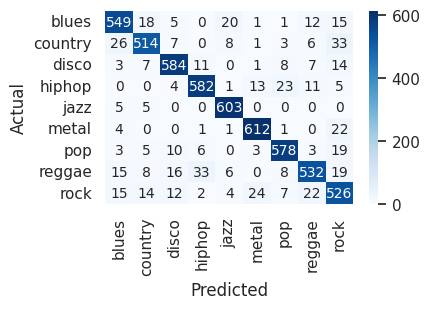

In [23]:
X, Y=x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-complete')
acc, y_test, y_pred= SVM1(X, Y)
plot_cm(y_test, y_pred, Y)

Size of train features matrix:  (11444, 200) , Size of train output vector:  (11444,)
Size of test features matrix:  (5637, 200) , Size of test output vector:  (5637,)
Accuracy:  0.9418130211105198
              precision    recall  f1-score   support

       blues       0.93      0.93      0.93       625
     country       0.92      0.92      0.92       618
       disco       0.96      0.95      0.96       634
      hiphop       0.95      0.96      0.96       597
        jazz       0.95      0.99      0.97       614
       metal       0.96      0.98      0.97       633
         pop       0.97      0.93      0.95       641
      reggae       0.96      0.92      0.94       636
        rock       0.88      0.89      0.88       639

    accuracy                           0.94      5637
   macro avg       0.94      0.94      0.94      5637
weighted avg       0.94      0.94      0.94      5637



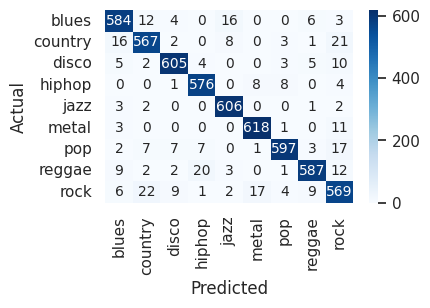

In [ ]:
#OPTIMIZED SVM:
C=1.295119532860652
gamma=0.0017947063324865531
kernel='rbf'

X, Y=x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-complete')
acc, y_test, y_pred= SVM_opt(X, Y, C, gamma, kernel)
plot_cm(y_test, y_pred, Y)


## 2.2 SVM: Percussive dataset: msd-musiscnn

Size of train features matrix:  (11444, 200) , Size of train output vector:  (11444,)
Size of test features matrix:  (5637, 200) , Size of test output vector:  (5637,)
Accuracy:  0.7807344332091538
              precision    recall  f1-score   support

       blues       0.65      0.79      0.71       625
     country       0.75      0.73      0.74       618
       disco       0.88      0.89      0.88       597
      hiphop       0.84      0.82      0.83       621
        jazz       0.81      0.80      0.81       634
       metal       0.83      0.86      0.84       634
         pop       0.80      0.79      0.80       630
      reggae       0.85      0.76      0.80       641
        rock       0.66      0.60      0.63       637

    accuracy                           0.78      5637
   macro avg       0.78      0.78      0.78      5637
weighted avg       0.78      0.78      0.78      5637



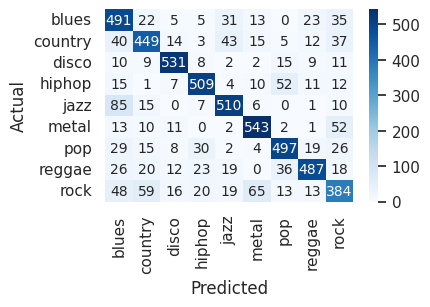

In [32]:
X, Y=x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-percu')
acc, y_test, y_pred= SVM1(X, Y)
plot_cm(y_test, y_pred, Y)


Size of train features matrix:  (11444, 200) , Size of train output vector:  (11444,)
Size of test features matrix:  (5637, 200) , Size of test output vector:  (5637,)
Accuracy:  0.8346638282774526
              precision    recall  f1-score   support

       blues       0.73      0.84      0.78       625
     country       0.80      0.80      0.80       618
       disco       0.91      0.91      0.91       597
      hiphop       0.90      0.86      0.88       621
        jazz       0.83      0.86      0.85       634
       metal       0.88      0.89      0.88       634
         pop       0.86      0.83      0.84       630
      reggae       0.89      0.82      0.86       641
        rock       0.74      0.71      0.72       637

    accuracy                           0.83      5637
   macro avg       0.84      0.84      0.84      5637
weighted avg       0.84      0.83      0.84      5637



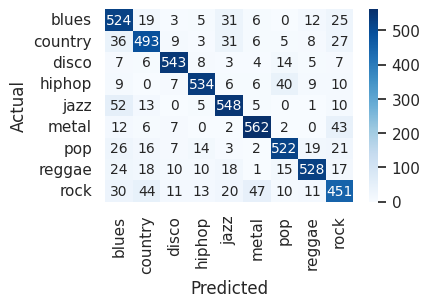

In [ ]:
#OPTIMIZED SVM:
C=1.295119532860652
gamma=0.0017947063324865531
kernel='rbf'

X, Y=x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-percu')
acc, y_test, y_pred= SVM_opt(X, Y, C, gamma, kernel)
plot_cm(y_test, y_pred, Y)


## 2.3 SVM: Harmonic dataset: msd-musiscnn

Size of train features matrix:  (11444, 200) , Size of train output vector:  (11444,)
Size of test features matrix:  (5637, 200) , Size of test output vector:  (5637,)
Accuracy:  0.8043285435515345
              precision    recall  f1-score   support

       blues       0.80      0.84      0.82       625
     country       0.81      0.80      0.81       618
       disco       0.68      0.68      0.68       597
      hiphop       0.88      0.83      0.86       621
        jazz       0.90      0.96      0.93       634
       metal       0.90      0.91      0.91       634
         pop       0.80      0.81      0.80       630
      reggae       0.75      0.78      0.76       641
        rock       0.70      0.62      0.65       637

    accuracy                           0.80      5637
   macro avg       0.80      0.80      0.80      5637
weighted avg       0.80      0.80      0.80      5637



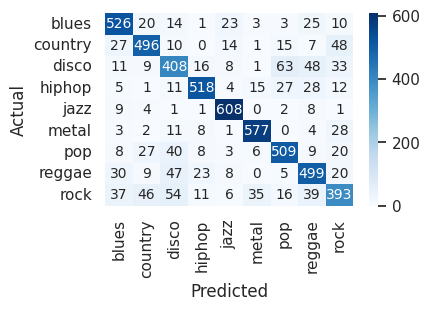

In [33]:
X, Y=x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-harmo')
acc, y_test, y_pred= SVM1(X, Y)
plot_cm(y_test, y_pred, Y)

Size of train features matrix:  (11444, 200) , Size of train output vector:  (11444,)
Size of test features matrix:  (5637, 200) , Size of test output vector:  (5637,)
Accuracy:  0.8302288451303885
              precision    recall  f1-score   support

       blues       0.83      0.87      0.85       625
     country       0.82      0.83      0.82       618
       disco       0.73      0.73      0.73       597
      hiphop       0.89      0.84      0.87       621
        jazz       0.92      0.97      0.95       634
       metal       0.91      0.92      0.92       634
         pop       0.83      0.83      0.83       630
      reggae       0.78      0.81      0.80       641
        rock       0.74      0.66      0.70       637

    accuracy                           0.83      5637
   macro avg       0.83      0.83      0.83      5637
weighted avg       0.83      0.83      0.83      5637



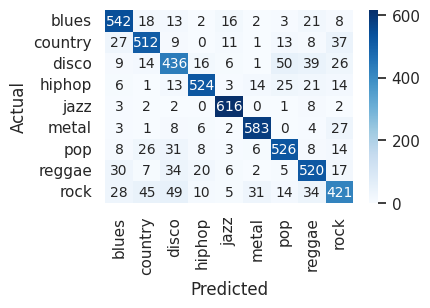

In [ ]:
#OPTIMIZED SVM:
C=1.295119532860652
gamma=0.0017947063324865531
kernel='rbf'

X, Y=x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/msd-musicnn-harmo')
acc, y_test, y_pred= SVM_opt(X, Y, C, gamma, kernel)
plot_cm(y_test, y_pred, Y)

## 2.4 SVM: Complete dataset: audioset-vgg

Size of train features matrix:  (19274, 128) , Size of train output vector:  (19274,)
Size of test features matrix:  (9494, 128) , Size of test output vector:  (9494,)
Accuracy:  0.7788076680008427
              precision    recall  f1-score   support

       blues       0.76      0.81      0.78      1079
     country       0.68      0.76      0.72      1049
       disco       0.76      0.74      0.75      1035
      hiphop       0.81      0.85      0.83      1035
        jazz       0.93      0.94      0.93      1043
       metal       0.88      0.89      0.89      1049
         pop       0.79      0.80      0.79      1048
      reggae       0.78      0.67      0.72      1088
        rock       0.62      0.57      0.59      1068

    accuracy                           0.78      9494
   macro avg       0.78      0.78      0.78      9494
weighted avg       0.78      0.78      0.78      9494



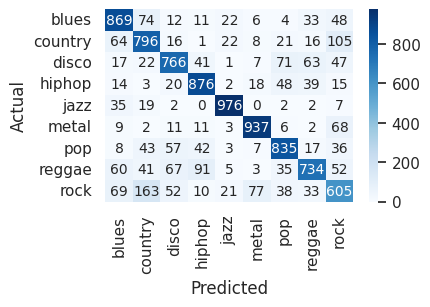

In [ ]:
#AUDIOSET-VGG NORMAL DATASET:

X, Y=x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/audioset-vgg-complete')
acc, y_test, y_pred= SVM1(X, Y)
plot_cm(y_test, y_pred, Y)

Size of train features matrix:  (19274, 128) , Size of train output vector:  (19274,)
Size of test features matrix:  (9494, 128) , Size of test output vector:  (9494,)
Accuracy:  0.7050768906677902
              precision    recall  f1-score   support

       blues       0.65      0.65      0.65      1079
     country       0.59      0.70      0.64      1049
       disco       0.68      0.68      0.68      1035
      hiphop       0.72      0.80      0.76      1035
        jazz       0.90      0.90      0.90      1043
       metal       0.88      0.87      0.88      1049
         pop       0.75      0.69      0.72      1048
      reggae       0.67      0.58      0.62      1088
        rock       0.51      0.49      0.50      1068

    accuracy                           0.71      9494
   macro avg       0.71      0.71      0.71      9494
weighted avg       0.71      0.71      0.70      9494



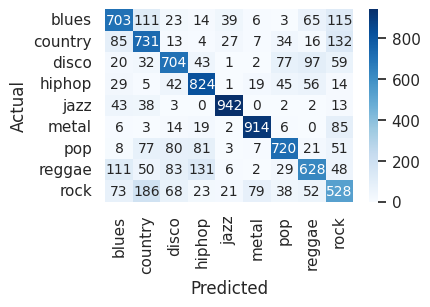

In [34]:
#OPTIMIZED SVM musicnn but applied for Vgg:
C=1.295119532860652
gamma=0.0017947063324865531
kernel='rbf'

X, Y=x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/audioset-vgg-complete')
acc, y_test, y_pred= SVM_opt(X, Y, C, gamma, kernel)
plot_cm(y_test, y_pred, Y)

Size of train features matrix:  (19274, 128) , Size of train output vector:  (19274,)
Size of test features matrix:  (9494, 128) , Size of test output vector:  (9494,)
Accuracy:  0.7656414577627976
              precision    recall  f1-score   support

       blues       0.74      0.79      0.76      1079
     country       0.67      0.75      0.71      1049
       disco       0.75      0.72      0.74      1035
      hiphop       0.79      0.84      0.81      1035
        jazz       0.92      0.93      0.93      1043
       metal       0.88      0.89      0.89      1049
         pop       0.78      0.78      0.78      1048
      reggae       0.77      0.65      0.70      1088
        rock       0.59      0.56      0.57      1068

    accuracy                           0.77      9494
   macro avg       0.77      0.77      0.77      9494
weighted avg       0.77      0.77      0.76      9494



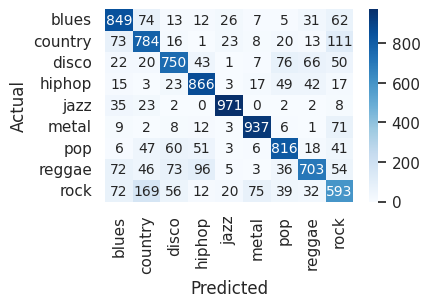

In [20]:
#OPTIMIZED SVM for vgg:
C_vgg =0.8662125829642671
gamma_vgg=0.1
kernel_vgg='rbf'

X, Y=x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/audioset-vgg-complete')
acc, y_test, y_pred= SVM_opt(X, Y, C_vgg, gamma_vgg, kernel_vgg)
plot_cm(y_test, y_pred, Y)

## 2.5 SVM: Percussive dataset: audioset-vgg

Size of train features matrix:  (19274, 128) , Size of train output vector:  (19274,)
Size of test features matrix:  (9494, 128) , Size of test output vector:  (9494,)
Accuracy:  0.5966926479882031
              precision    recall  f1-score   support

       blues       0.63      0.53      0.58      1035
     country       0.52      0.59      0.55      1049
       disco       0.63      0.71      0.67      1059
      hiphop       0.64      0.64      0.64      1045
        jazz       0.70      0.78      0.74      1069
       metal       0.63      0.73      0.68      1052
         pop       0.58      0.49      0.53      1084
      reggae       0.54      0.55      0.54      1041
        rock       0.47      0.34      0.40      1060

    accuracy                           0.60      9494
   macro avg       0.59      0.60      0.59      9494
weighted avg       0.59      0.60      0.59      9494



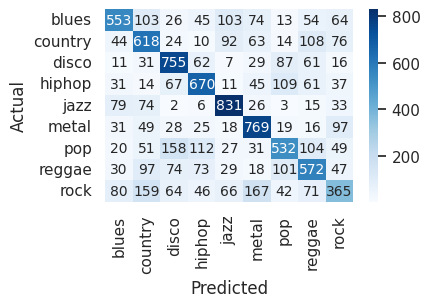

In [ ]:
#AUDIOSET-VGG PERCUSSIVE DATASET:

X, Y=x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/audioset-vgg-percu')
acc, y_test, y_pred= SVM1(X, Y)
plot_cm(y_test, y_pred, Y)

Size of train features matrix:  (19274, 128) , Size of train output vector:  (19274,)
Size of test features matrix:  (9494, 128) , Size of test output vector:  (9494,)
Accuracy:  0.4668211502001264
              precision    recall  f1-score   support

       blues       0.38      0.35      0.36      1035
     country       0.39      0.50      0.44      1049
       disco       0.50      0.68      0.58      1059
      hiphop       0.52      0.56      0.54      1045
        jazz       0.63      0.61      0.62      1069
       metal       0.57      0.60      0.59      1052
         pop       0.46      0.25      0.33      1084
      reggae       0.36      0.43      0.39      1041
        rock       0.36      0.22      0.27      1060

    accuracy                           0.47      9494
   macro avg       0.46      0.47      0.46      9494
weighted avg       0.46      0.47      0.46      9494



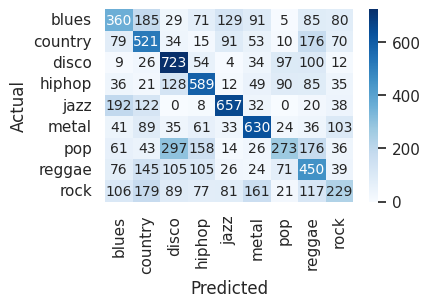

In [ ]:
#OPTIMIZED SVM musicnn but applied for Vgg:
C=1.295119532860652
gamma=0.0017947063324865531
kernel='rbf'

X, Y=x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/audioset-vgg-percu')
acc, y_test, y_pred= SVM_opt(X, Y, C, gamma, kernel)
plot_cm(y_test, y_pred, Y)

Size of train features matrix:  (19274, 128) , Size of train output vector:  (19274,)
Size of test features matrix:  (9494, 128) , Size of test output vector:  (9494,)
Accuracy:  0.570676216557826
              precision    recall  f1-score   support

       blues       0.59      0.49      0.53      1035
     country       0.49      0.57      0.53      1049
       disco       0.61      0.71      0.66      1059
      hiphop       0.60      0.62      0.61      1045
        jazz       0.68      0.76      0.72      1069
       metal       0.61      0.70      0.65      1052
         pop       0.56      0.46      0.51      1084
      reggae       0.50      0.52      0.51      1041
        rock       0.44      0.31      0.36      1060

    accuracy                           0.57      9494
   macro avg       0.56      0.57      0.56      9494
weighted avg       0.57      0.57      0.56      9494



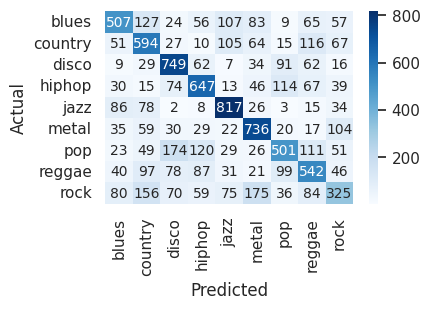

In [21]:
#OPTIMIZED SVM for VGG:percussive dataset
C_vgg =0.8662125829642671
gamma_vgg=0.1
kernel_vgg='rbf'

X, Y=x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/audioset-vgg-percu')
acc, y_test, y_pred= SVM_opt(X, Y, C_vgg, gamma_vgg, kernel_vgg)
plot_cm(y_test, y_pred, Y)

## 2.6 SVM: Harmonic dataset: audioset-vgg

Size of train features matrix:  (19274, 128) , Size of train output vector:  (19274,)
Size of test features matrix:  (9494, 128) , Size of test output vector:  (9494,)
Accuracy:  0.7000210659363809
              precision    recall  f1-score   support

       blues       0.74      0.72      0.73      1035
     country       0.67      0.69      0.68      1049
       disco       0.53      0.52      0.53      1059
      hiphop       0.72      0.80      0.76      1045
        jazz       0.88      0.89      0.88      1069
       metal       0.84      0.85      0.84      1052
         pop       0.69      0.71      0.70      1084
      reggae       0.62      0.64      0.63      1041
        rock       0.58      0.48      0.52      1060

    accuracy                           0.70      9494
   macro avg       0.70      0.70      0.70      9494
weighted avg       0.70      0.70      0.70      9494



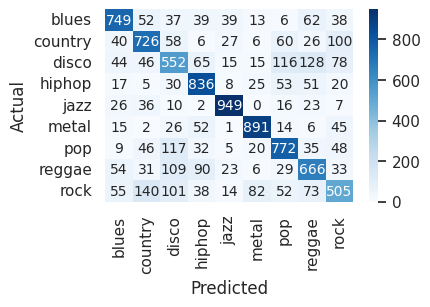

In [ ]:
#AUDIOSET-VGG Harmonic DATASET:

X, Y=x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/audioset-vgg-harmo')
acc, y_test, y_pred= SVM1(X, Y)
plot_cm(y_test, y_pred, Y)

Size of train features matrix:  (19274, 128) , Size of train output vector:  (19274,)
Size of test features matrix:  (9494, 128) , Size of test output vector:  (9494,)
Accuracy:  0.6233410575100063
              precision    recall  f1-score   support

       blues       0.64      0.62      0.63      1035
     country       0.60      0.61      0.60      1049
       disco       0.46      0.40      0.43      1059
      hiphop       0.63      0.77      0.69      1045
        jazz       0.85      0.84      0.85      1069
       metal       0.81      0.80      0.80      1052
         pop       0.63      0.64      0.63      1084
      reggae       0.49      0.58      0.53      1041
        rock       0.47      0.36      0.41      1060

    accuracy                           0.62      9494
   macro avg       0.62      0.62      0.62      9494
weighted avg       0.62      0.62      0.62      9494



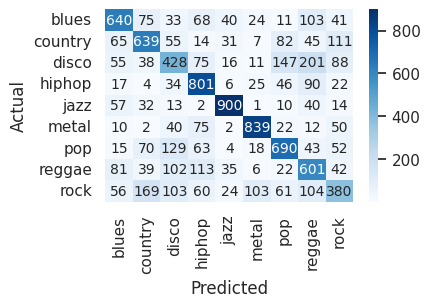

In [ ]:
#OPTIMIZED SVM musicnn but applied for Vgg:
C=1.295119532860652
gamma=0.0017947063324865531
kernel='rbf'

X, Y=x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/audioset-vgg-harmo')
acc, y_test, y_pred= SVM_opt(X, Y, C, gamma, kernel)
plot_cm(y_test, y_pred, Y)

Size of train features matrix:  (19274, 128) , Size of train output vector:  (19274,)
Size of test features matrix:  (9494, 128) , Size of test output vector:  (9494,)
Accuracy:  0.6805350747840742
              precision    recall  f1-score   support

       blues       0.70      0.70      0.70      1041
     country       0.65      0.69      0.67      1064
       disco       0.55      0.52      0.53      1079
      hiphop       0.69      0.78      0.73      1049
        jazz       0.87      0.88      0.88      1046
       metal       0.84      0.86      0.85      1040
         pop       0.65      0.69      0.67      1052
      reggae       0.59      0.59      0.59      1035
        rock       0.55      0.44      0.49      1088

    accuracy                           0.68      9494
   macro avg       0.68      0.68      0.68      9494
weighted avg       0.68      0.68      0.68      9494



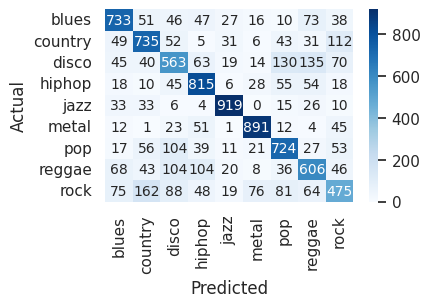

In [22]:
#OPTIMIZED SVM for VGG: harmonic
C_vgg =0.8662125829642671
gamma_vgg=0.1
kernel_vgg='rbf'

X, Y=x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/audioset-vgg-harmo')
acc, y_test, y_pred= SVM_opt(X, Y, C_vgg, gamma_vgg, kernel_vgg)
plot_cm(y_test, y_pred, Y)

## 2.7 SVM: Complete dataset: Effnet-dicogs

Size of train features matrix:  (16865, 200) , Size of train output vector:  (16865,)
Size of test features matrix:  (8307, 200) , Size of test output vector:  (8307,)
Accuracy:  0.9511255567593596
              precision    recall  f1-score   support

       blues       0.97      0.96      0.97       915
     country       0.94      0.94      0.94       945
       disco       0.97      0.97      0.97       921
      hiphop       0.96      0.95      0.96       927
        jazz       0.98      1.00      0.99       901
       metal       0.95      0.97      0.96       922
         pop       0.94      0.94      0.94       910
      reggae       0.99      0.94      0.97       920
        rock       0.86      0.89      0.88       946

    accuracy                           0.95      8307
   macro avg       0.95      0.95      0.95      8307
weighted avg       0.95      0.95      0.95      8307



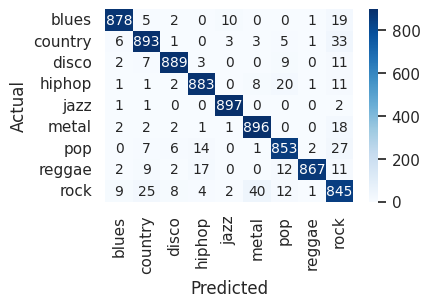

In [24]:
X, Y=x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-complete')
acc, y_test, y_pred= SVM1(X, Y)
plot_cm(y_test, y_pred, Y)

Size of train features matrix:  (16865, 200) , Size of train output vector:  (16865,)
Size of test features matrix:  (8307, 200) , Size of test output vector:  (8307,)
Accuracy:  0.9012880703021549
              precision    recall  f1-score   support

       blues       0.92      0.92      0.92       915
     country       0.90      0.87      0.89       945
       disco       0.93      0.93      0.93       921
      hiphop       0.91      0.90      0.90       927
        jazz       0.97      0.99      0.98       901
       metal       0.92      0.95      0.94       922
         pop       0.87      0.89      0.88       910
      reggae       0.99      0.86      0.92       920
        rock       0.74      0.81      0.77       946

    accuracy                           0.90      8307
   macro avg       0.90      0.90      0.90      8307
weighted avg       0.90      0.90      0.90      8307



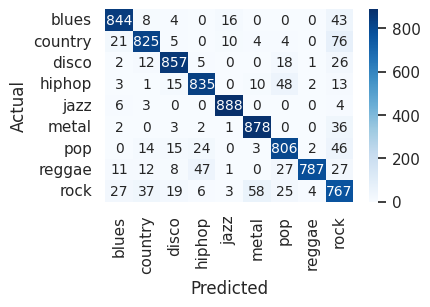

In [31]:
#OPTIMIZED SVM musicnn but applied for effnet:
C=1.295119532860652
gamma=0.0017947063324865531
kernel='rbf'

X, Y=x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-complete')
acc, y_test, y_pred= SVM_opt(X, Y, C, gamma, kernel)
plot_cm(y_test, y_pred, Y)

Size of train features matrix:  (16865, 200) , Size of train output vector:  (16865,)
Size of test features matrix:  (8307, 200) , Size of test output vector:  (8307,)
Accuracy:  0.9772481040086674
              precision    recall  f1-score   support

       blues       0.95      0.98      0.97       915
     country       0.98      0.98      0.98       945
       disco       0.99      0.98      0.98       921
      hiphop       0.98      0.97      0.98       927
        jazz       1.00      0.99      0.99       901
       metal       0.97      0.99      0.98       922
         pop       0.97      0.97      0.97       910
      reggae       1.00      0.97      0.98       920
        rock       0.96      0.95      0.96       946

    accuracy                           0.98      8307
   macro avg       0.98      0.98      0.98      8307
weighted avg       0.98      0.98      0.98      8307



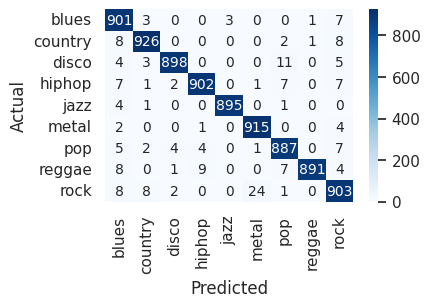

In [27]:
#OPTIMIZED SVM for Effnet: complete
C_effnet=0.8662125829642671
gamma_effnet= 0.1
kernel_effnet='rbf'

X, Y=x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-complete')
acc, y_test, y_pred= SVM_opt(X, Y, C_effnet, gamma_effnet, kernel_effnet)
plot_cm(y_test, y_pred, Y)

## 2.8 SVM: Percussive dataset: Effnet-dicogs

Size of train features matrix:  (16871, 200) , Size of train output vector:  (16871,)
Size of test features matrix:  (8311, 200) , Size of test output vector:  (8311,)
Accuracy:  0.8784743111538924
              precision    recall  f1-score   support

       blues       0.79      0.86      0.83       912
     country       0.82      0.83      0.83       945
       disco       0.97      0.94      0.95       958
      hiphop       0.94      0.90      0.92       925
        jazz       0.84      0.92      0.88       909
       metal       0.88      0.89      0.88       912
         pop       0.93      0.86      0.89       922
      reggae       0.96      0.91      0.94       906
        rock       0.78      0.80      0.79       922

    accuracy                           0.88      8311
   macro avg       0.88      0.88      0.88      8311
weighted avg       0.88      0.88      0.88      8311



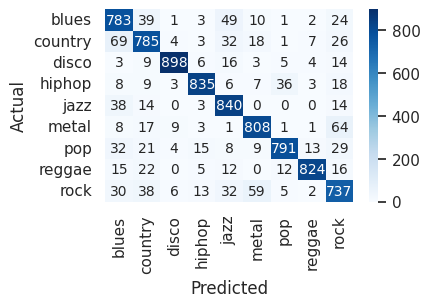

In [28]:
X, Y=x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-percu')
acc, y_test, y_pred= SVM1(X, Y)
plot_cm(y_test, y_pred, Y)

Size of train features matrix:  (16871, 200) , Size of train output vector:  (16871,)
Size of test features matrix:  (8311, 200) , Size of test output vector:  (8311,)
Accuracy:  0.8784743111538924
              precision    recall  f1-score   support

       blues       0.79      0.86      0.83       912
     country       0.82      0.83      0.83       945
       disco       0.97      0.94      0.95       958
      hiphop       0.94      0.90      0.92       925
        jazz       0.84      0.92      0.88       909
       metal       0.88      0.89      0.88       912
         pop       0.93      0.86      0.89       922
      reggae       0.96      0.91      0.94       906
        rock       0.78      0.80      0.79       922

    accuracy                           0.88      8311
   macro avg       0.88      0.88      0.88      8311
weighted avg       0.88      0.88      0.88      8311



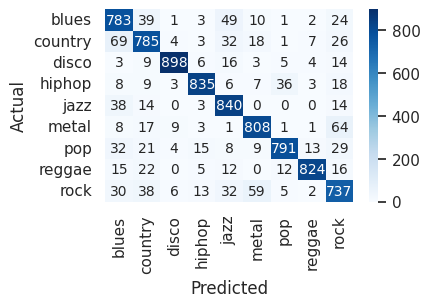

In [25]:
#OPTIMIZED SVM for Effnet: percu
C_effnet=0.8662125829642671
gamma_effnet= 0.1
kernel_effnet='rbf'
X, Y=x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-percu')
acc, y_test, y_pred= SVM_opt(X, Y, C_effnet, gamma_effnet, kernel_effnet)
plot_cm(y_test, y_pred, Y)

## 2.9 SVM: Harmonic dataset: Effnet-dicogs

Size of train features matrix:  (16871, 200) , Size of train output vector:  (16871,)
Size of test features matrix:  (8311, 200) , Size of test output vector:  (8311,)
Accuracy:  0.8623511009505475
              precision    recall  f1-score   support

       blues       0.88      0.90      0.89       919
     country       0.87      0.88      0.87       936
       disco       0.76      0.81      0.78       915
      hiphop       0.86      0.89      0.87       918
        jazz       0.97      0.96      0.97       921
       metal       0.91      0.93      0.92       929
         pop       0.83      0.83      0.83       921
      reggae       0.90      0.84      0.87       897
        rock       0.79      0.73      0.76       955

    accuracy                           0.86      8311
   macro avg       0.86      0.86      0.86      8311
weighted avg       0.86      0.86      0.86      8311



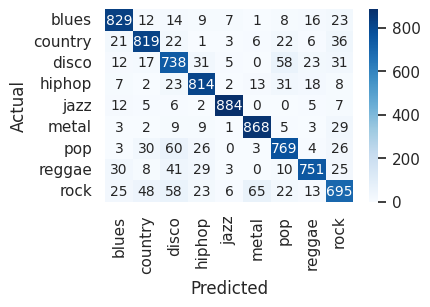

In [29]:
X, Y=x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-harmo')
acc, y_test, y_pred= SVM1(X, Y)
plot_cm(y_test, y_pred, Y)

Size of train features matrix:  (16871, 200) , Size of train output vector:  (16871,)
Size of test features matrix:  (8311, 200) , Size of test output vector:  (8311,)
Accuracy:  0.8623511009505475
              precision    recall  f1-score   support

       blues       0.88      0.90      0.89       919
     country       0.87      0.88      0.87       936
       disco       0.76      0.81      0.78       915
      hiphop       0.86      0.89      0.87       918
        jazz       0.97      0.96      0.97       921
       metal       0.91      0.93      0.92       929
         pop       0.83      0.83      0.83       921
      reggae       0.90      0.84      0.87       897
        rock       0.79      0.73      0.76       955

    accuracy                           0.86      8311
   macro avg       0.86      0.86      0.86      8311
weighted avg       0.86      0.86      0.86      8311



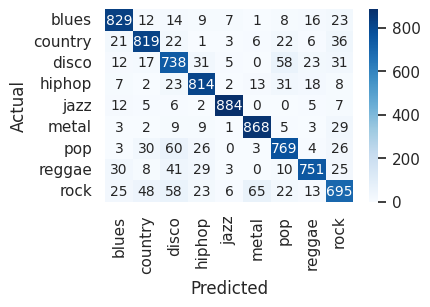

In [26]:
#OPTIMIZED SVM for Effnet: harmo
C_effnet=0.8662125829642671
gamma_effnet= 0.1
kernel_effnet='rbf'
X, Y=x_y_from_embeddings('/content/drive/MyDrive/GTZAN/Embeddings-Data/effnet-discogs-harmo')
acc, y_test, y_pred= SVM_opt(X, Y, C_effnet, gamma_effnet, kernel_effnet)
plot_cm(y_test, y_pred, Y)

# 3 - RESULTS

Results for SVM1 and SVM optimized

In [71]:
import pandas as pd


dataset = ["G_Normal", "G_Percu", "G_Harmo"]
musicnn_SVM1 = [0.90, 0.78, 0.80]
musicnn_SVMopt = [0.94, 0.83, 0.83]
vgg_SVM1 = [0.78, 0.60, 0.70]
vgg_SVMopt = [0.77, 57, 0.68]
effnet_SVM1 = [0.95, 0.88, 0.86]
effnet_SVMopt = [0.98, 0.88, 0.86]

#Dataframe from data
df = pd.DataFrame(list(zip(dataset, musicnn_SVM1, musicnn_SVMopt, vgg_SVM1, vgg_SVMopt,effnet_SVM1, effnet_SVMopt )),
                  columns=["Dataset", "Musicnn-SVM1",'musicnn-SVMopt', "VGG-SVM1", "VGG-SVMopt", "Effnet-SVM1", "Effnet-SVMopt"],
                  index=None)

col = ["Dataset", "Musicnn-SVM1",'musicnn-SVMopt', "VGG-SVM1", "VGG-SVMopt", "Effnet-SVM1", "Effnet-SVMopt"]
df.columns = col


#print(df.to_string(index=False))
df

,Dataset,Musicnn-SVM1,musicnn-SVMopt,VGG-SVM1,VGG-SVMopt,Effnet-SVM1,Effnet-SVMopt
0,G_Normal,0.90,0.94,0.78,0.77,0.95,0.98
1,G_Percu,0.78,0.83,0.60,57.00,0.88,0.88
2,G_Harmo,0.80,0.83,0.70,0.68,0.86,0.86


Best results

In [44]:
import pandas as pd


dataset = ["G_Normal", "G_Percu", "G_Harmo"]
musicnn = [0.94, 0.83, 0.83]
vgg = [0.78, 0.60, 0.70]
effnet = [0.98, 0.88, 0.86]

#Dataframe from data
df = pd.DataFrame(list(zip(dataset, musicnn, vgg, effnet)),
                  columns=["Dataset", "Musicnn", "VGG", "Effnet"],
                  index=None)

col = ["Dataset", "Musicnn", "VGG", "Effnet"]
df.columns = col


#print(df.to_string(index=False))
df

,Dataset,Musicnn,VGG,Effnet
0,G_Normal,0.94,0.78,0.98
1,G_Percu,0.83,0.60,0.88
2,G_Harmo,0.83,0.70,0.86


Best results distribuition

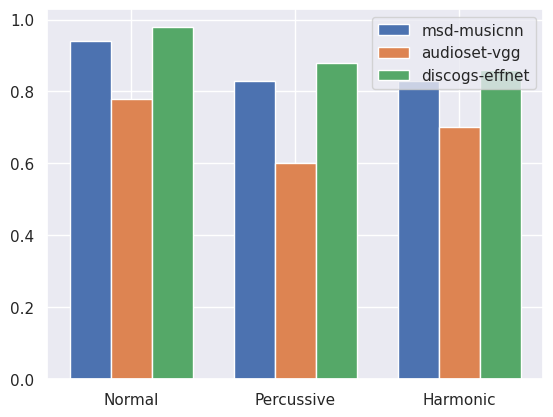

In [55]:
import pandas as pd 
import matplotlib.pyplot as plt
data = pd.DataFrame({'musicnn' : [0.94, 0.83, 0.83],
                     'vgg': [0.78, 0.60, 0.70],
                     'effnet': [0.98, 0.88, 0.86]},
                    index=('Normal', 'Percussive', 'Harmonic'))

n = len(data.index)
x = np.arange(n)
width = 0.25
plt.bar(x - width, data.musicnn, width=width, label='msd-musicnn')
plt.bar(x, data.vgg, width=width, label='audioset-vgg')
plt.bar(x + width, data.effnet, width=width, label='discogs-effnet')
plt.xticks(x, data.index)
plt.legend(loc='best')
plt.show()